Enter your RunPod API key:  ········


Sending request to start the job (GGUF model)...
Job successfully started with ID: daa6461f-3365-4f68-82d1-1bc2c319c5fe-u1
Polling for job status... (attempt 1)
Polling for job status... (attempt 2)
Polling for job status... (attempt 3)
Polling for job status... (attempt 4)
Polling for job status... (attempt 5)
Polling for job status... (attempt 6)
Polling for job status... (attempt 7)
Polling for job status... (attempt 8)
Polling for job status... (attempt 9)
Polling for job status... (attempt 10)
Polling for job status... (attempt 11)
Polling for job status... (attempt 12)
Polling for job status... (attempt 13)
Polling for job status... (attempt 14)
Polling for job status... (attempt 15)
Job completed successfully!

✓ Image successfully generated and saved as 'Z-Image\ComfyUI_00001_.png'


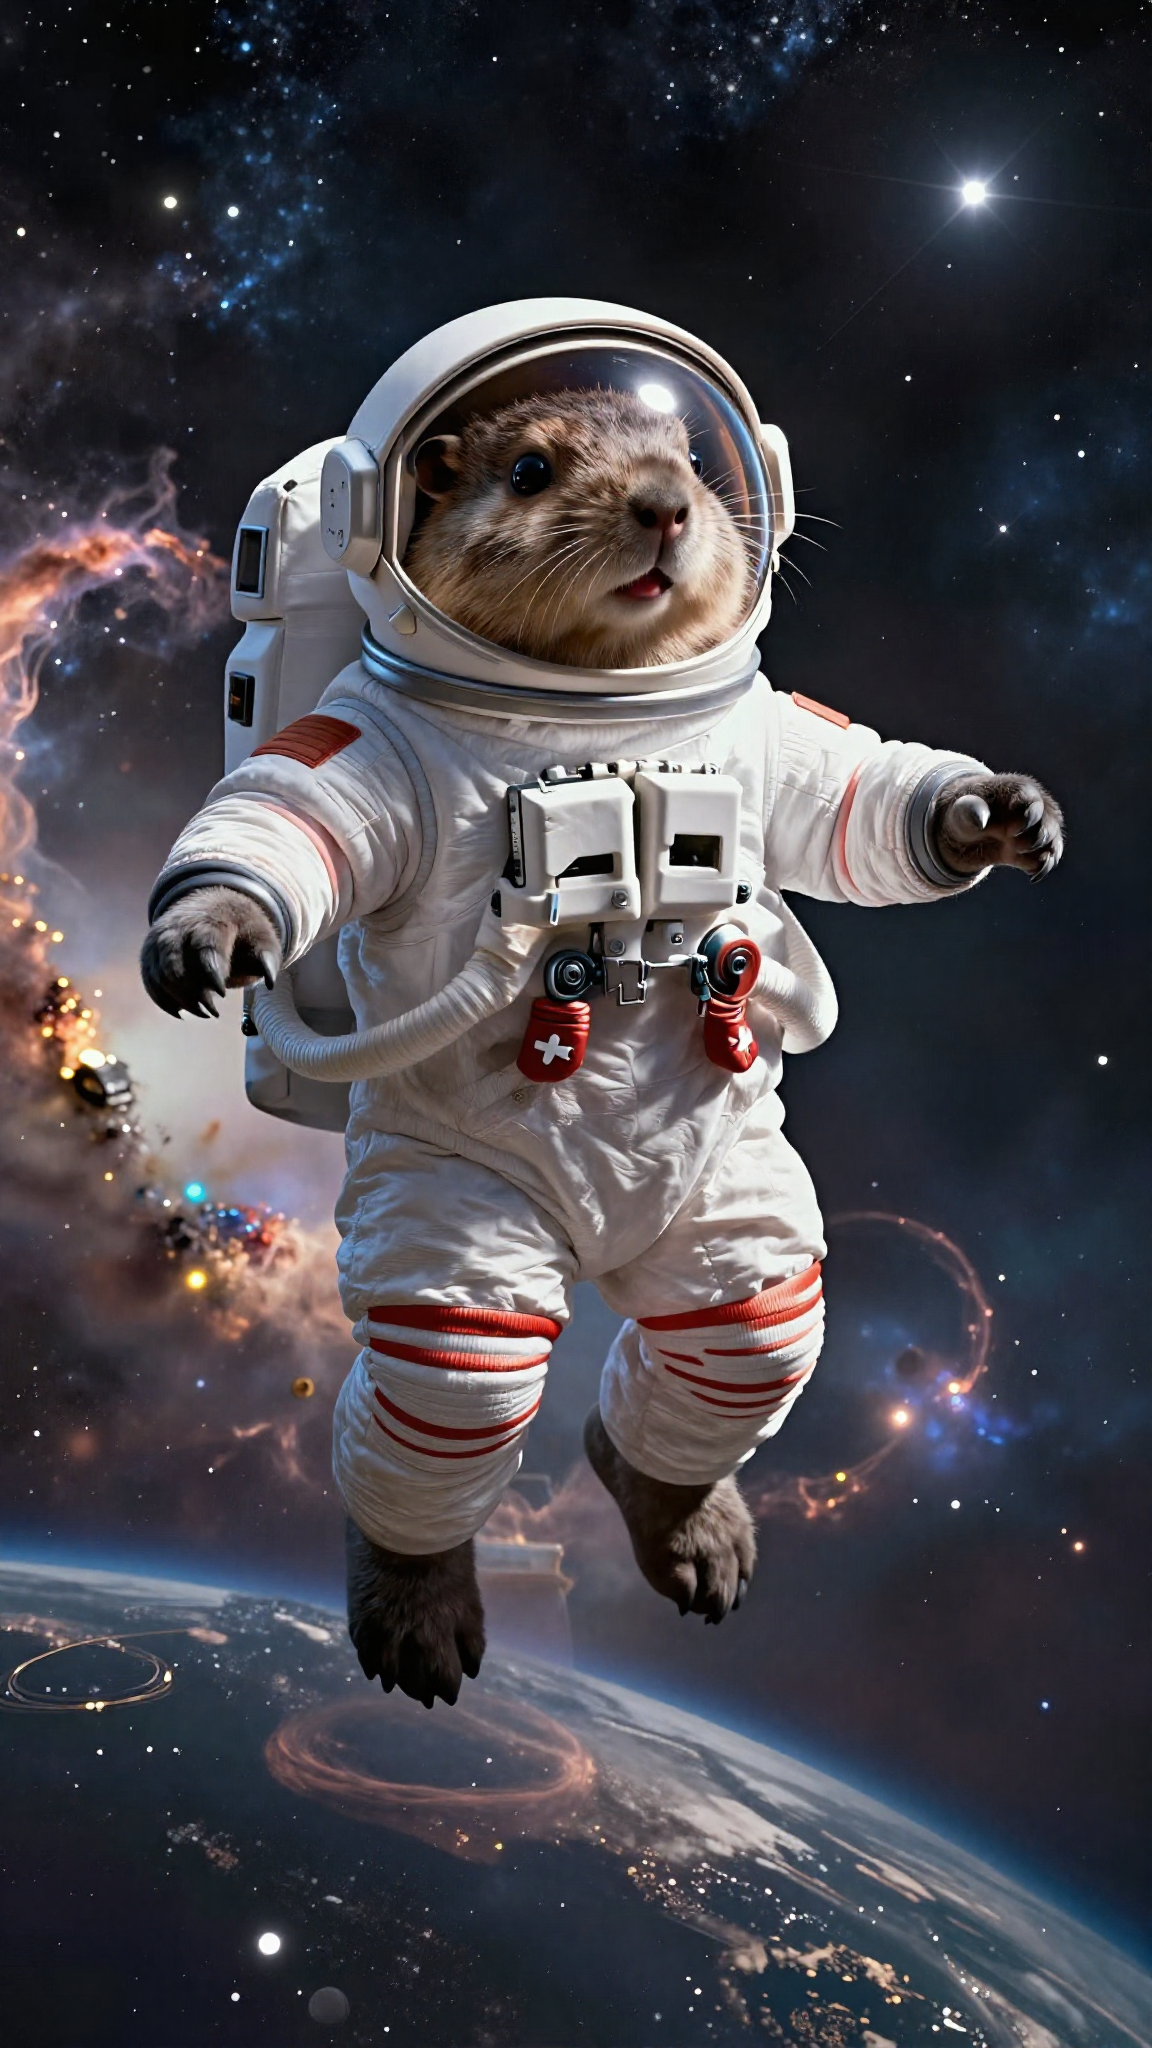

✓ Image displayed above



In [2]:
import requests
import base64
import json
import time
from PIL import Image
from io import BytesIO
from dotenv import load_dotenv 
import os

# --- 1. Configuration ---
load_dotenv()
api_key = os.getenv("RUNPOD_API_KEY")

if not api_key:
    from getpass import getpass
    api_key = getpass("Enter your RunPod API key: ")

endpoint_id = "a48mrbdsbzg35n"

# --- 2. Define the API URLs ---
run_url = f"https://api.runpod.ai/v2/{endpoint_id}/run"
status_url_template = f"https://api.runpod.ai/v2/{endpoint_id}/status/"

# --- 3. GGUF Workflow (Z-Image Turbo) ---
workflow_payload = {
    "input": {
        "workflow": {
            "9": {
                "inputs": {
                    "filename_prefix": "Z-Image\\ComfyUI",
                    "images": ["43", 0]
                },
                "class_type": "SaveImage",
                "_meta": {"title": "Save Image"}
            },
            "39": {
                "inputs": {
                    "clip_name": "qwen_3_4b.safetensors",
                    "type": "lumina2",
                    "device": "default"
                },
                "class_type": "CLIPLoader",
                "_meta": {"title": "Load CLIP"}
            },
            "40": {
                "inputs": {
                    "vae_name": "ae.safetensors"
                },
                "class_type": "VAELoader",
                "_meta": {"title": "Load VAE"}
            },
            "41": {
                "inputs": {
                    "width": 1152,
                    "height": 2048,
                    "batch_size": 1
                },
                "class_type": "EmptySD3LatentImage",
                "_meta": {"title": "EmptySD3LatentImage"}
            },
            "42": {
                "inputs": {
                    "conditioning": ["45", 0]
                },
                "class_type": "ConditioningZeroOut",
                "_meta": {"title": "ConditioningZeroOut"}
            },
            "43": {
                "inputs": {
                    "samples": ["44", 0],
                    "vae": ["40", 0]
                },
                "class_type": "VAEDecode",
                "_meta": {"title": "VAE Decode"}
            },
            "44": {
                "inputs": {
                    "seed": 1094413250754141,
                    "steps": 4,
                    "cfg": 1,
                    "sampler_name": "res_multistep",
                    "scheduler": "simple",
                    "denoise": 1,
                    "model": ["48", 0],
                    "positive": ["45", 0],
                    "negative": ["42", 0],
                    "latent_image": ["41", 0]
                },
                "class_type": "KSampler",
                "_meta": {"title": "KSampler"}
            },
            "45": {
                "inputs": {
                    "text": "1gopher, adorable anthropomorphic gopher wearing a miniature astronaut suit, floating peacefully in deep space, surrounded by glowing nebulae and distant stars, Earth visible in the background, cosmic dust particles reflecting starlight, zero gravity pose with arms slightly outstretched, realistic space photography, 8k, detailed fur texture visible through helmet visor, sense of wonder and tranquility",
                    "clip": ["39", 0]
                },
                "class_type": "CLIPTextEncode",
                "_meta": {"title": "CLIP Text Encode (Prompt)"}
            },
            "48": {
                "inputs": {
                    "unet_name": "z_image_turbo_bf16.safetensors",
                    "weight_dtype": "fp8_e4m3fn"  # Add this line
                },
                "class_type": "UNETLoader",
                "_meta": {"title": "Unet Loader"}
            }
        }
    }
}

# --- 4. Send the Initial API Request ---
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

print("Sending request to start the job (GGUF model)...")
response = requests.post(run_url, headers=headers, json=workflow_payload)

if response.status_code == 200:
    response_data = response.json()
    job_id = response_data.get('id')
    
    if not job_id:
        print("Error: API response did not include a job ID.")
        print("Full response:", json.dumps(response_data, indent=2))
    else:
        print(f"Job successfully started with ID: {job_id}")

        # --- 5. Poll for the Job Status ---
        status_url = status_url_template + job_id
        poll_count = 0
        while True:
            poll_count += 1
            print(f"Polling for job status... (attempt {poll_count})")
            status_response = requests.get(status_url, headers=headers)
            status_data = status_response.json()
            job_status = status_data.get('status')

            if job_status == 'COMPLETED':
                print("Job completed successfully!")
                
                # --- 6. Process the Final Output ---
                try:
                    output_image_data = status_data['output']['images'][0]
                    image_base64 = output_image_data['data'] 
                    filename = output_image_data['filename']

                    image_bytes = base64.b64decode(image_base64)
                    image = Image.open(BytesIO(image_bytes))
                    
                    # Save the image
                    image.save(filename)
                    print(f"\n✓ Image successfully generated and saved as '{filename}'")
                    
                    # Display the image (works in Jupyter notebooks)
                    try:
                        from IPython.display import display
                        display(image)
                        print("✓ Image displayed above\n")
                    except ImportError:
                        print("(Not in Jupyter - image saved but not displayed)\n")
                        # For non-Jupyter environments, try to show with PIL
                        try:
                            image.show()
                        except:
                            pass

                except (KeyError, IndexError, TypeError) as e:
                    print(f"\n✗ Error: Could not parse image data: {e}\n")
                    print("Full response:", json.dumps(status_data, indent=2))
                
                break

            elif job_status in ['IN_QUEUE', 'IN_PROGRESS']:
                time.sleep(5)
            elif job_status == 'FAILED':
                print(f"\n✗ Job execution failed.")
                print("Error details:", status_data.get('error', 'No error message provided'))
                if 'output' in status_data:
                    print("Output:", status_data['output'])
                break
            else:
                print(f"\n✗ Unexpected job status: {job_status}")
                print("Full response:", json.dumps(status_data, indent=2))
                break

else:
    print(f"✗ Error: Initial API request failed with status code {response.status_code}")
    print("Response:", response.text)